In [1]:
import os
import scipy
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from classy import Class
"Cosmological independent matrix"
import sys
sys.path.append('./FOLPS-nu/')
import FOLPSnu as FOLPS

In [3]:
#omega_i = Omega_i h² 
z_pk        = 1.0         #evaluation redshift
h           = 0.673       #h = H0/100
Mnu         = 0.0       #total mass of massive neutrino
omega_b     = 0.02224     #baryons
omega_cdm   = 0.1179       #CDM
omega_ncdm  = Mnu/93.14            
n_s         = 0.9624

logA        = 3.13
#bias parameters
b1          = 2.4                
b2          = 0.9                 
bs2         = -4/7*(b1 - 1);        
b3nl        = 32/315*(b1 - 1);
#EFT parameters
alpha0      = -48                 #units: [Mpc/h]^2
alpha2      = -20             #units: [Mpc/h]^2
alpha4      = 0.0               #units: [Mpc/h]^2
ctilde      = 1.4               #units: [Mpc/h]^4
#Stochatics parameters
sn0         = 0.15          
sn2         = -8          #units: [Mpc/h]^2      
PshotP      = 1/0.0002118763;    #units: [Mpc/h]^3

CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]
NuisanParams = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, sn0, sn2, PshotP]

In [4]:
def pklinear():
    pklinear_fn = f'pkl_cb_z{z_pk}.dat'
    if not os.path.exists(pklinear_fn):
        k_min = 0.10000E-03
        k_max = 0.10000E+03
        nuCDM = Class()
        params = {'omega_b':omega_b, 'omega_cdm':omega_cdm, 'h':h, 'ln10^{10}A_s':logA, 'n_s':n_s, 
                    'N_eff':3.046,  'N_ncdm':1, 'm_ncdm':Mnu,
                #   'tau_reio':0.09,'YHe':0.24,
                    'output':'mPk','z_pk':z_pk,'P_k_max_1/Mpc':k_max}
        nuCDM.set(params)
        nuCDM.compute()
        kk          = np.logspace(np.log10(k_min), np.log10(k_max), num = 312) #Mpc^-1
        Pk_linear   = []
        for k in kk:
            Pk_linear.append([k, nuCDM.pk_cb(k*nuCDM.h(),z_pk)*nuCDM.h()**3])
        nuCDM.empty()
        Pk_linear = np.array(Pk_linear).T
        np.savetxt(pklinear_fn, Pk_linear)
        return Pk_linear
    else:
        return np.loadtxt(pklinear_fn)

inputpkT    = pklinear() # linear power spectrum


In [5]:
matrices    = FOLPS.Matrices() # 10s

N = 128 sampling points
M matrices have been computed


In [6]:
Nonlinear = FOLPS.NonLinear(inputpkT, CosmoParams, kminout=10**(-4), kmaxout=10.0, nk=120)

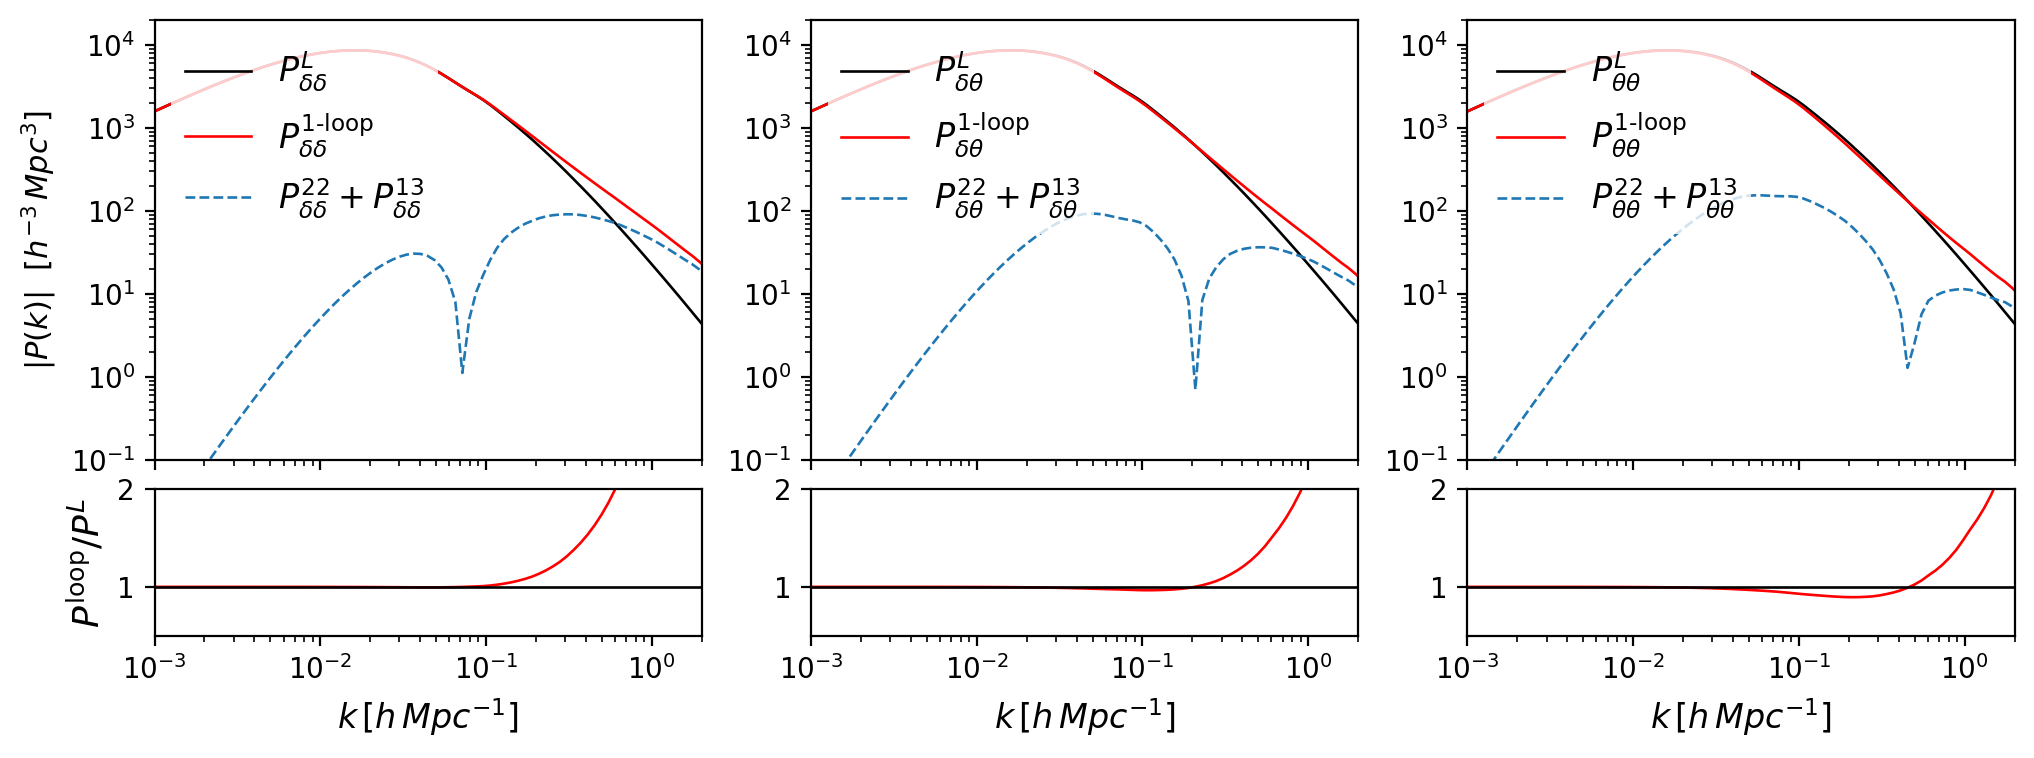

In [7]:
"LOOP CORRECTIONS"
krange = FOLPS.TableOut[0]; 
pkl    = FOLPS.TableOut[1]
pkl_NW    = FOLPS.TableOut_NW[1]
Fkoverf0  = FOLPS.TableOut_NW[2]
Pdt_L_NW = pkl_NW*Fkoverf0
Ptt_L_NW = pkl_NW*Fkoverf0**2
Ploop_dd_NW = FOLPS.TableOut_NW[3]
Ploop_dt_NW = FOLPS.TableOut_NW[4]
Ploop_tt_NW = FOLPS.TableOut_NW[5]

[P22dd, P22dt, P22tt] = FOLPS.P22[0:3]
[P22dd_NW, P22dt_NW, P22tt_NW] = FOLPS.P22_NW[0:3]
[P13dd, P13dt, P13tt] = FOLPS.P13overpkl[0:3]
[P13dd_NW, P13dt_NW, P13tt_NW] = FOLPS.P13overpkl_NW[0:3]

fig, axs = plt.subplots(2, 3, sharex=True, sharey=False, figsize = (12, 4), height_ratios=[3,1])
fig.subplots_adjust(hspace=0.1)
fig.subplots_adjust(wspace=0.2)
# First subplot
pkl = [pkl_NW , Pdt_L_NW, Ptt_L_NW]
pkloop = [ Ploop_dd_NW,  Ploop_dt_NW, Ploop_tt_NW]
Plabel1 = [r'$P^L_{\delta\delta}$', r'$P^L_{\delta\theta}$', r'$P^L_{\theta\theta}$']
Plabel2 = [r'$P^{\text{1-loop}}_{\delta\delta}$',r'$P^{\text{1-loop}}_{\delta\theta}$', r'$P^{\text{1-loop}}_{\theta\theta}$']
Plabel3 = [r'$P^{22}_{\delta\delta} + P^{13}_{\delta\delta}$',r'$P^{22}_{\delta\theta} + P^{13}_{\delta\theta}$', r'$P^{22}_{\theta\theta} + P^{13}_{\theta\theta}$']

for j in range(2):
    for i in range(3):
        if j == 0:
            p1, = axs[j][i].plot(krange, pkl[i], color='black', ls='-', label= Plabel1[i], lw=0.95)
            p2, = axs[j][i].plot(krange, pkl[i]+pkloop[i], color='red', ls='-', label=Plabel2[i], lw=0.95)
            p3, = axs[j][i].plot(krange, abs(pkloop[i]), color='C0', ls='--', label=Plabel3[i], lw=0.95)
            axs[j][i].set_yscale('log')
            axs[j][i].set_xscale('log')
            axs[j][i].set_xlim([0.001, 2]) 
            axs[j][i].set_ylim([0.1, 20000])
            leg1=axs[j,i].legend(handles=[p1, p2, p3], loc=2, fontsize=12)
            leg1.get_frame().set_linewidth(0.0)
        if j==1:
            axs[j][i].set_ylim([0.5, 2])
            axs[j][i].plot(krange,(pkloop[i]+pkl[i])/pkl[i], color='red', ls='-', label=r'$P^{L}_{\delta\delta}$', lw=0.95)
            axs[j][i].axhline(y=1, color = 'black',ls = '-', lw=0.95)
            axs[j][i].set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize=12)
        if i ==0 and j==0: 
            axs[j][i].set_ylabel(r'$|P(k)|$  $[h^{-3} \, Mpc^{3}]$', fontsize=11)
        if i ==0 and j==1: 
            axs[j][i].set_ylabel(r'$P^{\text{loop}} / P^L$', fontsize=13)
plt.show()


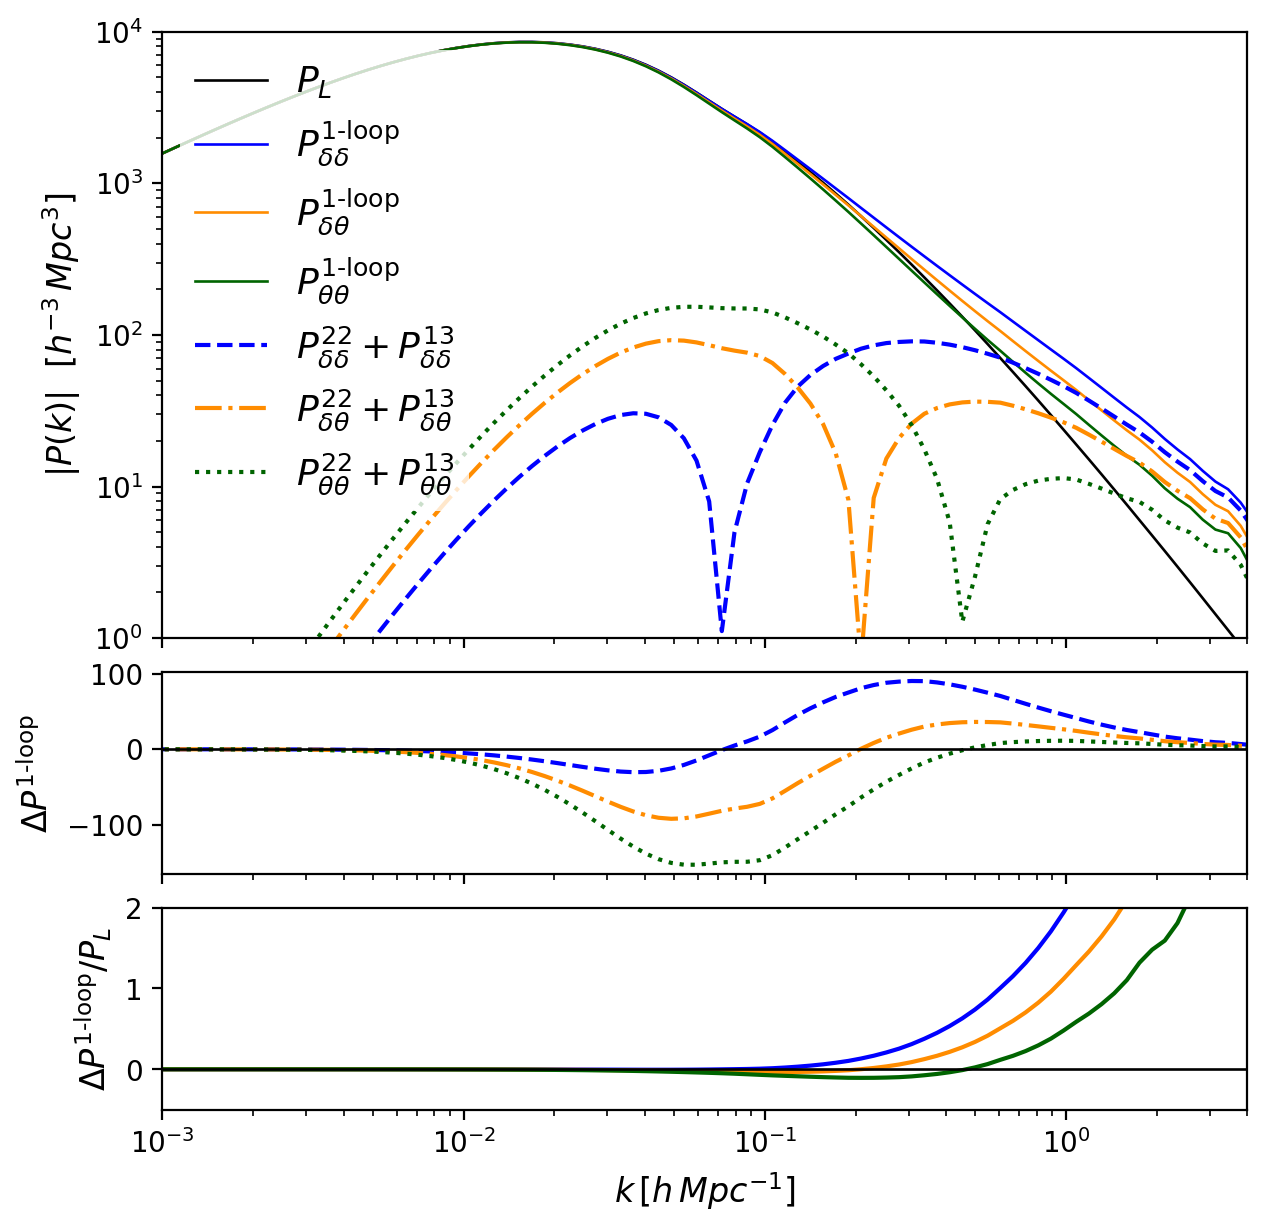

In [8]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey=False, figsize = (7, 7), height_ratios=[3, 1, 1])
fig.subplots_adjust(hspace=0.1)
# First subplot
axs[0].plot(krange, pkl_NW, color='black', ls='-', label=r'$P_{L}$', lw=0.95)
axs[0].plot(krange, pkl_NW+Ploop_dd_NW, color='blue', ls='-', label=r'$P^{\text{1-loop}}_{\delta \delta}$', lw=0.95)
axs[0].plot(krange, Pdt_L_NW+Ploop_dt_NW, color='darkorange', ls='-', label=r'$P^{\text{1-loop}}_{\delta \theta}$', lw=0.95)
axs[0].plot(krange, Ptt_L_NW+Ploop_tt_NW, color='darkgreen', ls='-', label=r'$P^{\text{1-loop}}_{\theta \theta}$', lw=0.95)
axs[0].plot(krange, abs(Ploop_dd_NW), color = 'blue', ls='--',label = r'$P_{\delta \delta}^{22} + P_{\delta \delta}^{13}$')
axs[0].plot(krange, abs(Ploop_dt_NW), color = 'darkorange', ls='-.',label = r'$P_{\delta \theta}^{22} + P_{\delta \theta}^{13}$')
axs[0].plot(krange, abs(Ploop_tt_NW), color = 'darkgreen', ls=':',label = r'$P_{\theta \theta}^{22} + P_{\theta \theta}^{13}$')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylabel(r'$|P(k)|$  $[h^{-3} \, Mpc^{3}]$', fontsize=12)
axs[0].set_xlim([0.001, 4])
axs[0].set_ylim([10**0, 10**4])
leg1=axs[0].legend(loc=2, fontsize=13)
leg1.get_frame().set_linewidth(0.0)
# Second subplot
axs[2].plot(krange, (Ploop_dd_NW)/pkl_NW, color='blue', ls='-', label=r'$P_{\delta \delta}$')
axs[2].plot(krange, (Ploop_dt_NW)/Pdt_L_NW, color='darkorange', ls='-', label=r'$P_{\delta \theta}$')
axs[2].plot(krange, (Ploop_tt_NW)/pkl_NW, color='darkgreen', ls='-', label=r'$P_{\theta \theta}$')
axs[2].axhline(y=0, color = 'black',ls = '-', lw=0.95)
axs[2].set_ylim(-0.5,2)
axs[2].set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize=12)
axs[2].set_ylabel(r'$\Delta P^{\text{1-loop}}/P_L$', fontsize=12)

axs[1].plot(krange, (Ploop_dd_NW), color='blue', ls='--', label=r'$P_{\delta \delta}$')
axs[1].plot(krange, (Ploop_dt_NW), color='darkorange', ls='-.', label=r'$P_{\delta \theta}$')
axs[1].plot(krange, (Ploop_tt_NW), color='darkgreen', ls=':', label=r'$P_{\theta \theta}$')
axs[1].axhline(y=0, color = 'black',ls = '-', lw=0.95)
axs[1].set_ylabel(r'$\Delta P^{\text{1-loop}}$', fontsize=12)
plt.show()

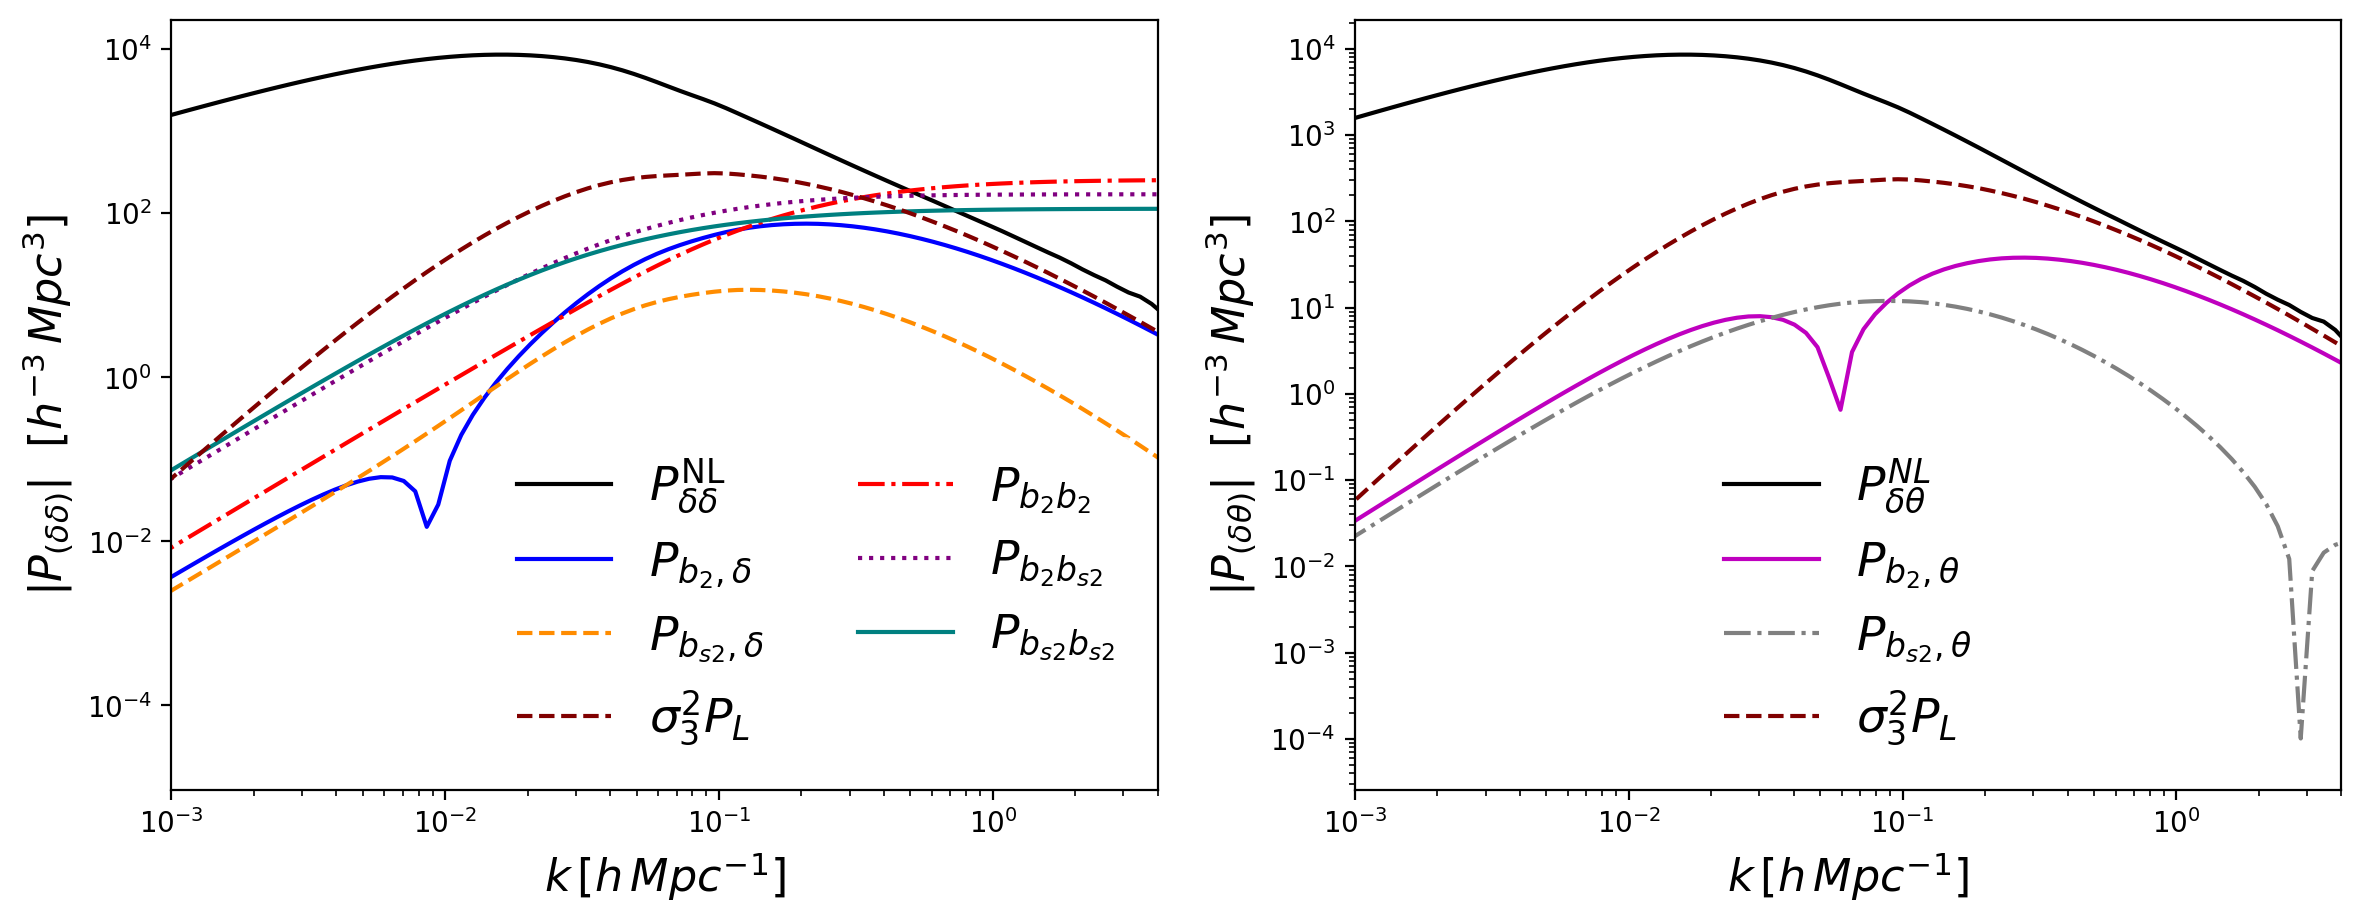

In [9]:
#Biasing 
#delta-delta
Pb1b2 = FOLPS.TableOut_NW[6]; 
Pb1bs2 =FOLPS.TableOut_NW[7]; 
Pb2b2 = FOLPS.TableOut_NW[8];
Pb2bs2 = FOLPS.TableOut_NW[9]; 
Pb2s2 = FOLPS.TableOut_NW[10]; 
sigma23pkl = FOLPS.TableOut_NW[11];
#delta-theta
Pb2t = FOLPS.TableOut_NW[12]; 
Pbs2t = FOLPS.TableOut_NW[13];

fig, axs = plt.subplots(1, 2, figsize = (14, 5),sharex=True)
p11,= axs[0].plot(krange, np.abs(pkl_NW+Ploop_dd_NW), color = 'black', label=r'$P^{\text{NL}}_{\delta \delta}$')
p12,= axs[0].plot(krange, np.abs(Pb1b2), color = 'blue', ls='-',label=r'$P_{b_2, \delta}$')
p13, = axs[0].plot(krange, np.abs(Pb1bs2), color = 'darkorange', ls='--',label=r'$P_{b_{s2}, \delta}$')
p21, = axs[0].plot(krange, np.abs(Pb2b2), color = 'r', ls='-.',label=r'$P_{b_2 b_2}$')
p22,= axs[0].plot(krange, np.abs(Pb2bs2), color = 'purple', ls=':',label=r'$P_{b_2 b_{s2}}$')
p23, = axs[0].plot(krange, np.abs(Pb2s2), color = 'teal', ls='-',label=r'$P_{b_{s2} b_{s2}}$')
p14, = axs[0].plot(krange, np.abs(sigma23pkl), color = 'maroon', ls='--',label=r'$\sigma^2_3 P_L$')
axs[0].set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  16)
axs[0].set_ylabel(r'$|P_{(\delta \delta)}|$  $[h^{-3} \, Mpc^{3}]$', fontsize =  16)
axs[0].set_xscale('log')
axs[0].set_yscale('log')

leg1_label = [r'$P^{\text{NL}}_{\delta \delta}$', r'$P_{b_2, \delta}$', r'$P_{b_{s2}, \delta}$', r'$\sigma^2_3 P_L$' ]
# axs[0].set_ylim([10**(-5),10**4])
leg1 = axs[0].legend(handles=[p11,p12,p13,p14, p21, p22, p23], loc = 'lower right', fontsize = 17, ncol=2)
leg1.get_frame().set_linewidth(0.0)
# leg1 = axs[0].legend(loc = 'lower center', fontsize = 15)
# leg1.get_frame().set_linewidth(0.0)
axs[1].plot(krange, np.abs(Pdt_L_NW+Ploop_dt_NW), color = 'black', label=r'$P^{NL}_{\delta \theta}$')
axs[1].plot(krange, np.abs(Pb2t), color = 'm', ls='-',label=r'$P_{b_2, \theta}$')
axs[1].plot(krange, np.abs(Pbs2t), color = 'grey', ls='-.',label=r'$P_{b_{s2}, \theta}$')
axs[1].plot(krange, np.abs(sigma23pkl), color = 'maroon', ls='--',label=r'$\sigma^2_3 P_L$')
axs[1].set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  16)
axs[1].set_ylabel(r'$|P_{(\delta \theta)}|$  $[h^{-3} \, Mpc^{3}]$', fontsize =  16)
# axs[0].set_ylim([10**(-2), 2*10**3])
axs[1].set_xlim([0.001, 4])
axs[1].set_xscale('log')
axs[1].set_yscale('log')
leg2 = axs[1].legend(loc = 'lower center', fontsize =  17)
leg2.get_frame().set_linewidth(0.0)

plt.show()


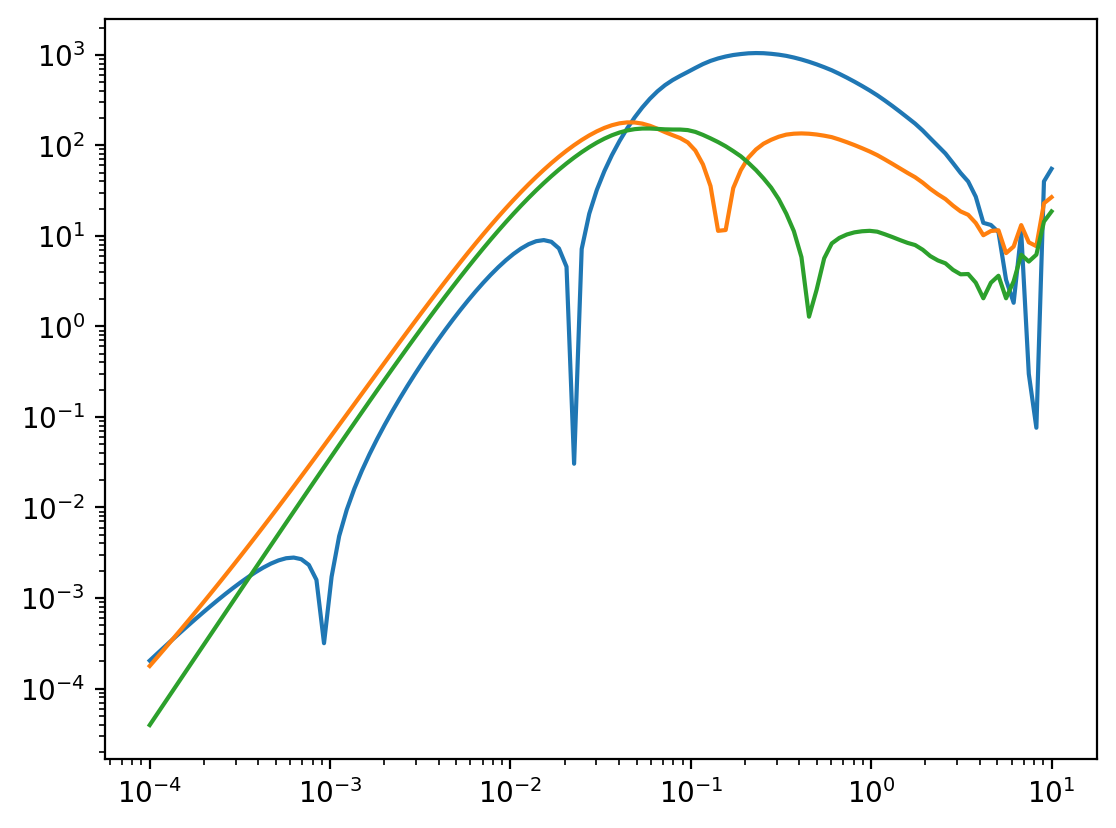

In [10]:
PddXloop = b1**2*Ploop_dd_NW+2*b1*b2*Pb1b2+2*b1*bs2*Pb1bs2+b2**2*Pb2b2+ 2*b2*bs2*Pb2bs2+bs2**2 *Pb2s2+2*b1*b3nl*sigma23pkl
PdtXloop = b1*Ploop_dt_NW + b2*Pb2t + bs2*Pbs2t + b3nl*Fkoverf0*sigma23pkl
PttXloop = Ploop_tt_NW
plt.plot(krange, abs(PddXloop))
plt.plot(krange, abs(PdtXloop))
plt.plot(krange, abs(PttXloop))
plt.xscale('log')
plt.yscale('log')